# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load Library and Data

To make a clear and concise description of our work. We organize most of our code into two seperate modules. 

- Core, it contains all of our critical code, i.e., Dataset and Classifier
- Utility, it contains our utility functions for illustrating our data

In [1]:
# all critical code are given in core
import core
# utility functions are given in utility module
import utility
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

ds = core.Dataset("../data")

---

## 1 Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### 1.1 Summarize the Data

In [2]:
utility.summarize_data(ds)

Number of training examples =  34799
Number of validation examples =  4410
Number of testing examples =  12630
Image data shape =  (32, 32, 3)
Number of classes (labels) =  43


### 1.2 Observe the Data

Visualize the German Traffic Signs Dataset using the pickled file(s). This include: 

- plotting traffic sign images, 
- plotting the count of each sign, etc. 

#### Plotting Traffic Sign

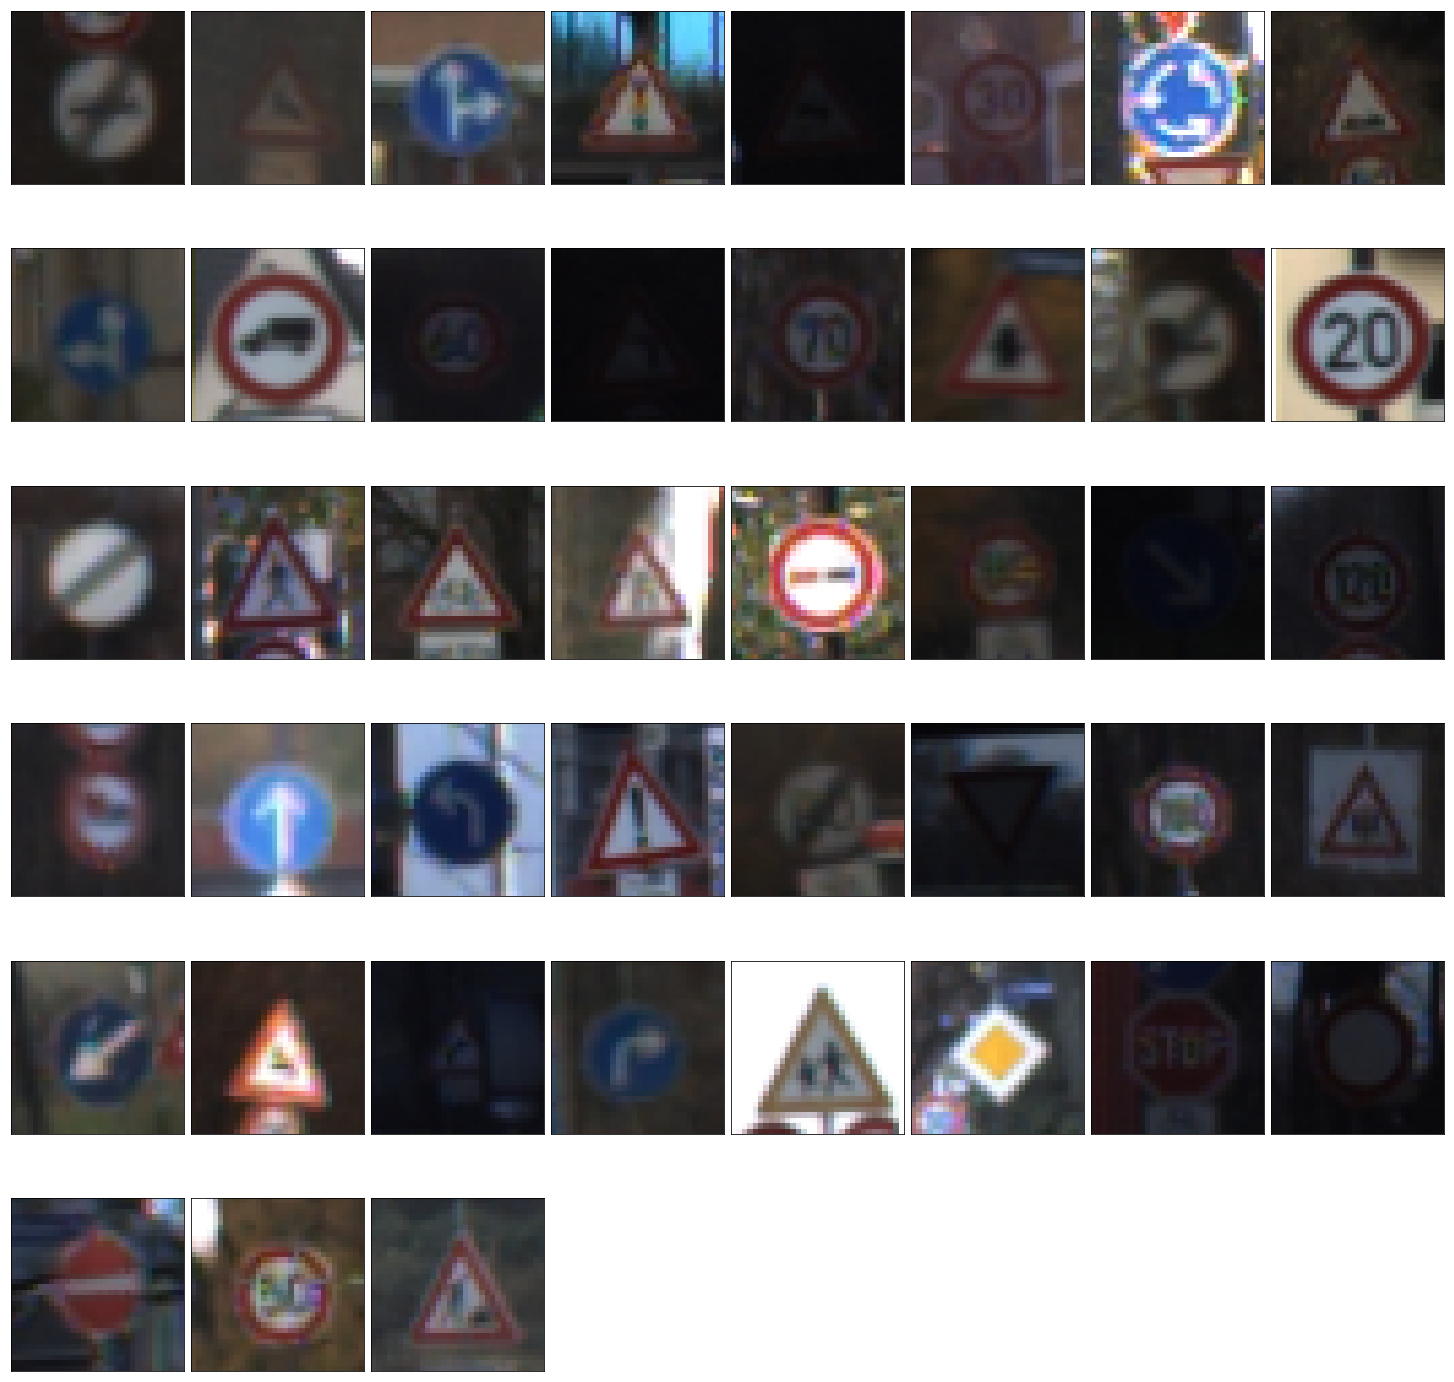

In [3]:
# plot one image for each type of sign
utility.plot_sign_images(ds)

#### Calculate Count of Each Sign

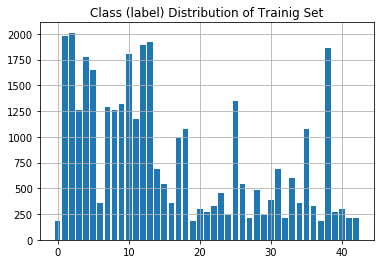

In [4]:
unique_train, counts_train = np.unique(ds.get_train()[-1], return_counts=True)
plt.bar(unique_train, counts_train)
plt.grid()
plt.title("Class (label) Distribution of Trainig Set")
plt.show()

----

## 2 Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### 2.1 Pre-processing

Our preprocessing consists of two steps:

- We convert source RGB images into grayscale images as lines and shapes provide enough information for traffic sign identification

- We normalize the value of grayscale images to (-1, 1) to enable fast and stable convergence -- without it the value range of features might vary and in our learning the correction applied in each dimension might vary. 

- We generate fake data for labels if the sample size of the label is less than a user specified bar to avoid labels with significantly large sample size being biased. We generate fake data via following steps: (1) select an image of the label randomly; (2) roatate the image by a random degree (-10, 10); (3) blur the image with gaussian smoothing with a random kernel size (1, 3); (4) zoom out the image to size (32 + inc, 32 + inc) with inc being a random integer value no less than 5. Note we cannot generate too much fake data (like 1000 samples per label) as this will lead to worse performance compared with the situation without doing so. In our experiements, we use 400 as our best choice. 

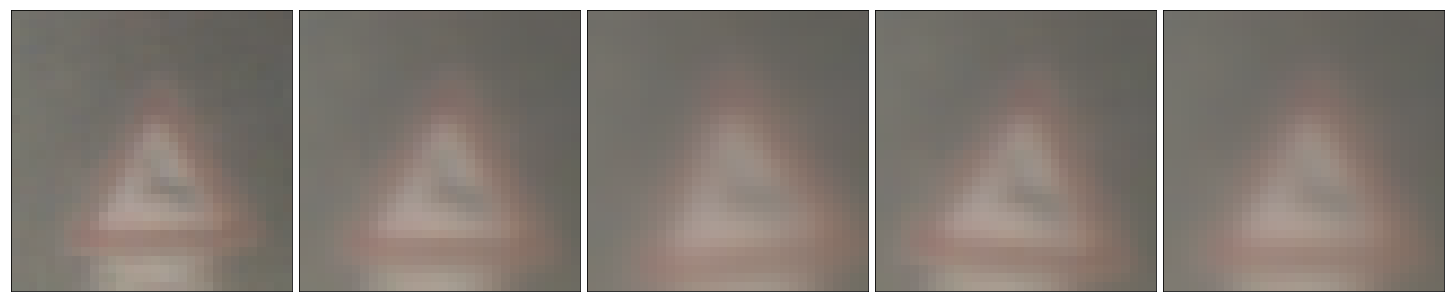

In [5]:
X_tmp, y_tmp = ds.get_train()
select = X_tmp[400]
demo = [select]
for _ in range(4):
    demo.append(utility.generate_noisy_image(select))
utility.show_images(demo, cols=5)

### 2.2 Model Architecture

![lanet](resources/lanet.png)

We use the classical LaNet network, consisting of 2 convolutional layers and 3 fully connected layers. Note we have a dropouts immediately after the 2nd convolutional layer. Below is a step-by-step breakdown of the model architecture with input being 32x32x1 grayscale images. 

- Convolution (kernel size: 5x5, stride: 1x1): output 28x28x6
- Relu
- Max pooling (kernel size: 2x2, stride: 2x2): output 14x14x6
- Convolution (kernel size: 5x5, stride: 1x1): output 10x10x16
- Relu
- Max pooling (kernel size: 2x2, stride: 2x2): output 5x5x16
- Flatten: output 400
- Dropout: output 400 * keep_prob
- Fully connected: output 120
- Relu
- Fully connected: output 84
- Relu
- Fully connected: output 43 (number of classes of our data)

### 2.3 Model Training

We use Adam optimizer to minimize the loss function, which is a known default method better than stochastic gradient discent. We use the following hyperparameters in the training. 

- Learning rate: 0.00075
- Number of epochs: 100
- Batch size: 128
- Keep probability for dropouts: 0.5
- Standard deviation for weights initialization: 0.01

### 2.4 Validate Model

We evaluate model after each epoch. At 40th epoch, our validation accuracy stays over **94%** steadily. The highest validation accuracy observed is 96%, but this caused two misprediction in our new test images due to overfitting (different hyperparameter setting). 

In [6]:
classifier = core.Classifier(ds, mu=0, sigma=0.01, 
                             keep_prob=0.5, rate=0.00075, 
                             epochs=80, batch_size=128, 
                             target_size=400)
classifier.train()

Original data shape  (34799, 32, 32, 3) (34799,) 2470
Preprocessed data shape:  (37269, 32, 32, 1) (37269,)
Training starts

EPOCH 1
Train set Accuracy = 0.052
Validation set Accuracy = 0.055

EPOCH 2
Train set Accuracy = 0.360
Validation set Accuracy = 0.354

EPOCH 3
Train set Accuracy = 0.536
Validation set Accuracy = 0.520

EPOCH 4
Train set Accuracy = 0.635
Validation set Accuracy = 0.621

EPOCH 5
Train set Accuracy = 0.716
Validation set Accuracy = 0.682

EPOCH 6
Train set Accuracy = 0.773
Validation set Accuracy = 0.758

EPOCH 7
Train set Accuracy = 0.815
Validation set Accuracy = 0.794

EPOCH 8
Train set Accuracy = 0.849
Validation set Accuracy = 0.825

EPOCH 9
Train set Accuracy = 0.873
Validation set Accuracy = 0.832

EPOCH 10
Train set Accuracy = 0.884
Validation set Accuracy = 0.847

EPOCH 11
Train set Accuracy = 0.896
Validation set Accuracy = 0.861

EPOCH 12
Train set Accuracy = 0.902
Validation set Accuracy = 0.864

EPOCH 13
Train set Accuracy = 0.903
Validation set Accur

### 2.5 Test Model

In [7]:
classifier.test(*classifier.get_test())

INFO:tensorflow:Restoring parameters from ./lenet
Test Set Accuracy = 0.939


---

## 3 Test a Model on New Images

We download the 5 new test images from https://github.com/ser94mor/traffic-sign-classifier. Each of the image name contains the label the image belongs to. The traffic signs we include are given as below:

- Speed limit (30km/h): label 1
- Right-of-way at the next intersection: label 11
- Priority road: label 12
- Stop: label 14
- No vehicles: label 15

The new images are displayed as below. 

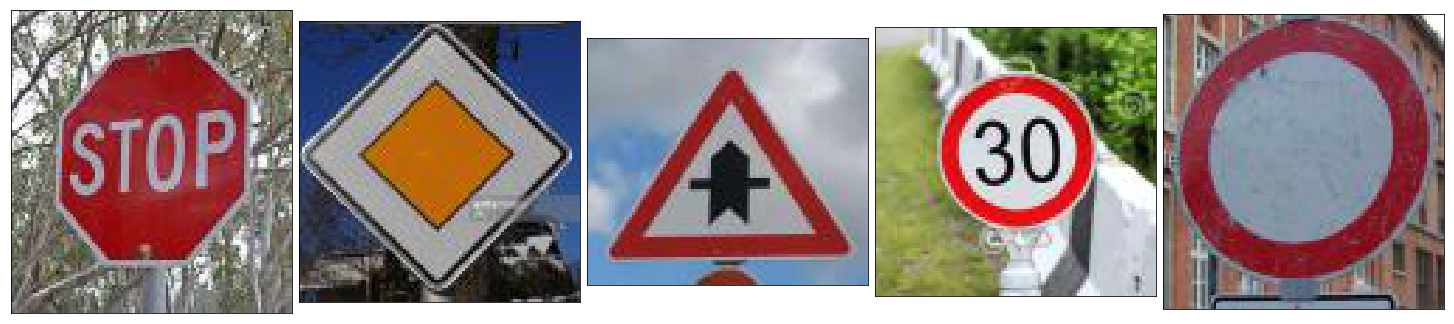

In [8]:
utility.show_new_data()

### 3.1 Preprocess Data

We did the following to the preprocessing:

- resize the image to our required sizes (32x32)
- preprocess the images with grayscale conversion and normalization

In [9]:
images, labels = utility.get_new_data(ds.get_size_of_image()[:2])

### 3.2 Predict Label and Analyze Performance

In [10]:
classifier.test(images, labels)
predictions, top5s = classifier.get_prediction_details(images, labels)

INFO:tensorflow:Restoring parameters from ./lenet
Test Set Accuracy = 1.000
INFO:tensorflow:Restoring parameters from ./lenet


The mispredicted label pairs, if any, include:

In [11]:
mispredicted = ["Label expected is {}, but label predicted is {}".format(expected, predicted)
                for expected, predicted in zip(labels, predictions) if expected != predicted]
for msg in mispredicted:
    print(msg)

### 3.3 Output Top 5 Softmax Probabilities For Each Image

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

In [12]:
print(top5s.values)
print(top5s.indices)

[[  9.73632812e-01   2.43905913e-02   1.67271239e-03   1.69229505e-04
    4.85454948e-05]
 [  9.99999762e-01   1.59818441e-07   9.45678238e-08   1.11757503e-09
    3.90905580e-12]
 [  1.00000000e+00   2.13622577e-08   3.92097105e-10   1.31977929e-10
    6.15066956e-11]
 [  9.16332483e-01   7.57231265e-02   7.85820931e-03   8.41379224e-05
    1.28613033e-06]
 [  8.32073331e-01   1.43308014e-01   7.06136692e-03   6.05386030e-03
    4.36712196e-03]]
[[14 33 17 34  3]
 [12 40 38 36 35]
 [11 30 24 21 27]
 [ 1  2 14  0  5]
 [15  2  1  3  5]]


---
## Appendix

In [13]:
utility.summarize_data(ds, show_classes=True)

Number of training examples =  34799
Number of validation examples =  4410
Number of testing examples =  12630
Image data shape =  (32, 32, 3)
Number of classes (labels) =  43
The class (label) names are listed as below
Speed limit (20km/h)
Speed limit (30km/h)
Speed limit (50km/h)
Speed limit (60km/h)
Speed limit (70km/h)
Speed limit (80km/h)
End of speed limit (80km/h)
Speed limit (100km/h)
Speed limit (120km/h)
No passing
No passing for vehicles over 3.5 metric tons
Right-of-way at the next intersection
Priority road
Yield
Stop
No vehicles
Vehicles over 3.5 metric tons prohibited
No entry
General caution
Dangerous curve to the left
Dangerous curve to the right
Double curve
Bumpy road
Slippery road
Road narrows on the right
Road work
Traffic signals
Pedestrians
Children crossing
Bicycles crossing
Beware of ice/snow
Wild animals crossing
End of all speed and passing limits
Turn right ahead
Turn left ahead
Ahead only
Go straight or right
Go straight or left
Keep right
Keep left
Roundab